# 01 - Implementation of Generative Adversarial Network (GAN)
 
 
    GAN from "https://arxiv.org/pdf/1406.2661.pdf" (2014, I. J. Goodfellow et. al.)

    Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)

    Author-email:  mskang@handong.edu

    python and pytorch version: python=3.7, pytorch=1.6

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, imsave

%matplotlib inline

# Step 00. Hyperparameter Setting

In [2]:
# Dataset Info.
dataset_path = '~/datasets'
kwargs = {'num_workers': 1, 'pin_memory': True} 
noise_dim=100
sample_dim = 784
num_class = 1

# CUDA and GPU Info.
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# Training info.
batch_size = 100
test_batch_size = 10
lr = 0.0002
epochs = 30
discriminator_train_step = 1
# Model hyperparameter Info.

# Step 01. Download Dataset

In [3]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

# Step 02. Define Model

In [4]:
# Simple MLP Generator

class Generator(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        
        self.linears = nn.Sequential(
        
            nn.Linear(input_dim, 128),
            nn.ReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(0.2),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = x
        return self.linears(y_)

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        
        self.linears = nn.Sequential(
        
            nn.Linear(input_dim, 512),
            nn.ReLU(0.2),
            nn.Linear(512, 256),
            nn.ReLU(0.2),
            nn.Linear(256, 128),
            nn.ReLU(0.2),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        y_ = x
        return self.linears(y_)

In [6]:
G = Generator(input_dim=noise_dim, output_dim=sample_dim).to(DEVICE)
D = Discriminator(input_dim=sample_dim, output_dim=num_class).to(DEVICE)

# Step 03. Define Loss function and optimizer

In [7]:
criterion = nn.BCELoss()

D_optim = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_optim = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

# Step 04. Train GAN

In [8]:
def train_D(D, G, x, noise, D_labels, D_fakes):
    x_fake = G(noise)
    y_hat = D(x)
    y_hat_fake = D(x_fake)
    return criterion(y_hat, D_labels) + criterion(y_hat_fake, D_fakes)

def train_G(D, G, D_labels, noise):
    x_fake = G(noise)
    return criterion(D(x_fake), D_labels)

In [9]:
print("Start training GAN...")

D_labels = torch.ones([batch_size, 1]).to(DEVICE) #  Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

for epoch in range(epochs):
    epoch_G_loss = 0
    epoch_D_loss = 0
    
    for batch_idx, (x, label) in enumerate(train_loader):
        x = x.view(batch_size, sample_dim)
        
        noise = torch.randn((batch_size, noise_dim)).to(DEVICE)
        x = x.to(DEVICE)
        
        # Train Discriminator
        G.eval()
        for _ in range(discriminator_train_step):
            D_optim.zero_grad()
            D_loss = train_D(D, G, x, noise, D_labels, D_fakes)
            D_loss.backward()
            D_optim.step()
        
        
        # Train Generator
        G.train()
        G_optim.zero_grad()
        G_loss = train_G(D, G, D_labels, noise)
        G_loss.backward()
        G_optim.step()
        
        epoch_G_loss += G_loss.item()
        epoch_D_loss += D_loss.item()
        
    print("\tEpoch", epoch + 1, "\tGenerator Loss: ", epoch_G_loss / (batch_idx*batch_size), "\tDiscriminator Loss: ", epoch_D_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training GAN...
	Epoch 1 	Generator Loss:  0.011601072767491333 	Discriminator Loss:  0.009413117905192463
	Epoch 2 	Generator Loss:  0.01429567059536211 	Discriminator Loss:  0.009911645809079649
	Epoch 3 	Generator Loss:  0.013157659753385887 	Discriminator Loss:  0.010811941748071393
	Epoch 4 	Generator Loss:  0.012713390530051294 	Discriminator Loss:  0.01079118327226782
	Epoch 5 	Generator Loss:  0.01279915591064399 	Discriminator Loss:  0.010706074231853071
	Epoch 6 	Generator Loss:  0.012727348758700694 	Discriminator Loss:  0.010812173176289401
	Epoch 7 	Generator Loss:  0.012391743042532708 	Discriminator Loss:  0.010925943396724326
	Epoch 8 	Generator Loss:  0.012009915823928501 	Discriminator Loss:  0.011183724011324085
	Epoch 9 	Generator Loss:  0.011984539844953955 	Discriminator Loss:  0.011162618331996745
	Epoch 10 	Generator Loss:  0.01203858581130612 	Discriminator Loss:  0.011204926722833828
	Epoch 11 	Generator Loss:  0.012083611378884673 	Discriminator Loss:  

# Step 05. Generate image samples

In [10]:
def get_sample_image(G, noise_dim=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        z = torch.randn(test_batch_size, noise_dim).to(DEVICE)
        x_hat = G(z).view(test_batch_size, 28, 28)
        result = x_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

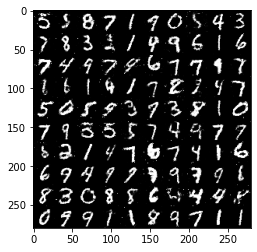

In [11]:
G.eval()
imshow(get_sample_image(G, noise_dim=noise_dim), cmap='gray')